In [223]:
!pip install tensorflow==2.16.1 opencv-python matplotlib

In [225]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [226]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [227]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [228]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [229]:
# http://vis-www.cs.umass.edu/lfw/
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

tar: Error opening archive: Failed to open 'lfw.tgz'


In [230]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [231]:
# Import uuid library to generate unique image names
import uuid

In [232]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\373c1f99-34bf-11ef-88be-60452e6c644c.jpg'

In [233]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

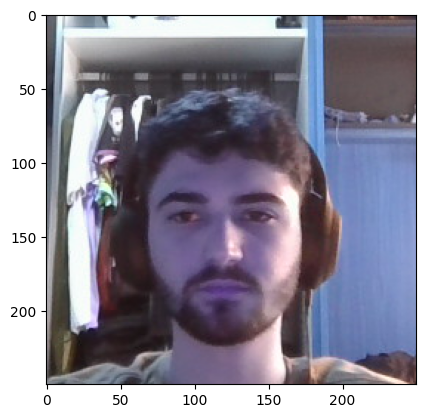

In [234]:
plt.imshow(frame[:250,:250, :])

In [235]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH + '\\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH + '\\*.jpg').take(3000)

In [236]:
dir_test = anchor.as_numpy_iterator()

In [237]:
print(dir_test.next())

b'data\\anchor\\df77b7f1-325c-11ef-8fa2-60452e6c644c.jpg'


In [238]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [239]:
img = preprocess('data\\anchor\\e1b4ea4c-325c-11ef-a448-60452e6c644c.jpg')

In [240]:
img.numpy().max() 

1.0

In [241]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [242]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [243]:
samples = data.as_numpy_iterator()

In [244]:
example = samples.next()

In [245]:
example

(b'data\\anchor\\dfcf7efb-325c-11ef-9e8f-60452e6c644c.jpg',
 b'data\\positive\\34b88e73-325d-11ef-b844-60452e6c644c.jpg',
 1.0)

In [246]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [247]:
res = preprocess_twin(*example)

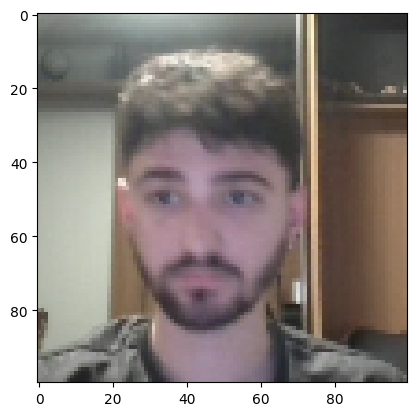

In [248]:
plt.imshow(res[1])

In [249]:
res[2]

1.0

In [250]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [251]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [252]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [253]:
inp = Input(shape=(100,100,3), name='input_image')

In [254]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [255]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [256]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)

In [257]:
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [258]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)

In [259]:
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [260]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)

In [261]:
f1 = Flatten()(c4)

In [262]:
d1 = Dense(4096, activation='sigmoid')(f1)

In [263]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [264]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [265]:
# Define the embedding model
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [266]:
sample_input = tf.random.normal([1, 100, 100, 3])
sample_output = embedding(sample_input)
print(type(sample_output))  # Ensure this is a tensor
print(sample_output.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 4096)


In [267]:
embedding = make_embedding()

In [268]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [269]:
# Define the L1Dist layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [270]:
l1 = L1Dist()

In [271]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [272]:
# Build the Siamese model
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    # Get the embeddings
    inp_embedding = embedding(input_image)
    val_embedding = embedding(validation_image)
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(inp_embedding, val_embedding)
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [273]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_33 (L1Dist)           │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_20 (Dense)              │ (None, 1)                 │           4,097 │ l1_dist_33[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [274]:
anchor_image = tf.random.normal([1, 100, 100, 3])
validation_image = tf.random.normal([1, 100, 100, 3])

In [275]:
inp_embedding = embedding(anchor_image)
val_embedding = embedding(validation_image)

In [276]:
print(type(inp_embedding))
print(type(val_embedding))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [277]:
siamese_layer = L1Dist()

In [278]:
distances = siamese_layer(inp_embedding, val_embedding)
print(distances)

tf.Tensor([[0.01075456 0.00472349 0.00046387 ... 0.01388317 0.00379926 0.00608924]], shape=(1, 4096), dtype=float32)


In [279]:
classifier = Dense(1, activation='sigmoid')(distances)
print(classifier)

tf.Tensor([[0.5026025]], shape=(1, 1), dtype=float32)


In [280]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

ValueError: When providing `inputs` as a list/tuple, all values in the list/tuple must be KerasTensors. Received: inputs=[<KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=None, name=input_img>, <tf.Tensor: shape=(1, 100, 100, 3), dtype=float32, numpy=
array([[[[-0.40380988,  0.8634559 , -0.88922095],
         [-0.8761787 ,  0.8153364 ,  0.29345748],
         [ 0.5034184 , -0.19900413,  0.29920074],
         ...,
         [ 0.03724708, -0.75533116,  0.13629507],
         [ 0.7151064 ,  1.4782642 ,  0.49496195],
         [-1.8361527 , -0.16559064,  0.62464136]],

        [[-1.9443129 ,  0.64850634, -0.7566316 ],
         [ 0.88514316,  0.12294697,  0.8228275 ],
         [ 0.1305257 ,  0.30353737, -1.1945854 ],
         ...,
         [-0.08301716, -1.8410267 ,  0.27024338],
         [ 0.9068674 ,  1.6117913 ,  1.6510801 ],
         [ 1.2813432 ,  2.3658414 ,  0.5386176 ]],

        [[-1.3908186 ,  0.13228549, -1.192253  ],
         [ 2.3361182 , -0.94129235,  0.07797699],
         [ 1.159749  ,  0.15222642, -1.1758908 ],
         ...,
         [ 0.59439045, -0.27930278, -1.8822937 ],
         [ 0.44057554, -0.65618414, -1.7276593 ],
         [ 1.3086153 , -0.5115907 , -0.18115169]],

        ...,

        [[ 1.5980215 ,  1.4427602 ,  0.02010085],
         [ 0.3737969 , -0.9989443 ,  0.18769565],
         [-0.18517038, -1.3076998 , -0.8128784 ],
         ...,
         [-1.0302665 , -1.320462  , -0.14927074],
         [ 0.9264002 ,  0.731466  ,  0.11386072],
         [-0.4588641 ,  0.43891203, -0.18423769]],

        [[ 0.18704072,  0.11613222, -1.4399906 ],
         [ 1.5310401 , -0.00412133, -1.1363881 ],
         [ 1.9027253 ,  0.21463168,  0.59739864],
         ...,
         [-1.4850346 , -1.5193791 ,  0.28666905],
         [-0.65193194, -0.7914021 , -0.18101089],
         [-0.9395947 ,  0.29912153, -0.8245761 ]],

        [[ 1.1920741 ,  0.7078117 , -0.8284022 ],
         [ 1.6027839 , -0.6580992 ,  1.201977  ],
         [-0.87366134,  0.93051374,  0.02919123],
         ...,
         [-0.38149628, -1.4711467 , -0.20238882],
         [-1.861225  ,  1.1589484 , -1.6928911 ],
         [ 1.7519773 , -1.3200028 ,  0.42716932]]]], dtype=float32)>] including invalid value [[[[-0.40380988  0.8634559  -0.88922095]
   [-0.8761787   0.8153364   0.29345748]
   [ 0.5034184  -0.19900413  0.29920074]
   ...
   [ 0.03724708 -0.75533116  0.13629507]
   [ 0.7151064   1.4782642   0.49496195]
   [-1.8361527  -0.16559064  0.62464136]]

  [[-1.9443129   0.64850634 -0.7566316 ]
   [ 0.88514316  0.12294697  0.8228275 ]
   [ 0.1305257   0.30353737 -1.1945854 ]
   ...
   [-0.08301716 -1.8410267   0.27024338]
   [ 0.9068674   1.6117913   1.6510801 ]
   [ 1.2813432   2.3658414   0.5386176 ]]

  [[-1.3908186   0.13228549 -1.192253  ]
   [ 2.3361182  -0.94129235  0.07797699]
   [ 1.159749    0.15222642 -1.1758908 ]
   ...
   [ 0.59439045 -0.27930278 -1.8822937 ]
   [ 0.44057554 -0.65618414 -1.7276593 ]
   [ 1.3086153  -0.5115907  -0.18115169]]

  ...

  [[ 1.5980215   1.4427602   0.02010085]
   [ 0.3737969  -0.9989443   0.18769565]
   [-0.18517038 -1.3076998  -0.8128784 ]
   ...
   [-1.0302665  -1.320462   -0.14927074]
   [ 0.9264002   0.731466    0.11386072]
   [-0.4588641   0.43891203 -0.18423769]]

  [[ 0.18704072  0.11613222 -1.4399906 ]
   [ 1.5310401  -0.00412133 -1.1363881 ]
   [ 1.9027253   0.21463168  0.59739864]
   ...
   [-1.4850346  -1.5193791   0.28666905]
   [-0.65193194 -0.7914021  -0.18101089]
   [-0.9395947   0.29912153 -0.8245761 ]]

  [[ 1.1920741   0.7078117  -0.8284022 ]
   [ 1.6027839  -0.6580992   1.201977  ]
   [-0.87366134  0.93051374  0.02919123]
   ...
   [-0.38149628 -1.4711467  -0.20238882]
   [-1.861225    1.1589484  -1.6928911 ]
   [ 1.7519773  -1.3200028   0.42716932]]]] of type <class 'tensorflow.python.framework.ops.EagerTensor'>

In [281]:
siamese_network.summary()

NameError: name 'siamese_network' is not defined

In [282]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [283]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [284]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [286]:
test_batch = train_data.as_numpy_iterator()

In [287]:
batch_1 = test_batch.next()

In [288]:
X = batch_1[:2]

In [289]:
y = batch_1[2]

In [295]:
y

array([0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1.],
      dtype=float32)

In [296]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](https://en.wikipedi

In [297]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss